# ALMA-IMF+SPICY: SED Fitting Analysis

Workspace for importing the astropy table generated by the Tingle SED Fitter notebook and analyzing/representing the data in helpful ways.

In [1]:
from plot_fit import *
from astropy.stats import mad_std

In [2]:
# read in and convert the saved fit_results_tbl into a dict
fit_results_tbl = Table.read('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/fit_results')
fit_results = deconstruct_fitinfo_tbl(fit_results_tbl)
del(fit_results_tbl)

spicyids = list(fit_results.keys())

  0%|          | 0/118 [00:00<?, ?it/s]

In [3]:
fit_results_tbl = Table.read('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/fit_results')

In [4]:
# comparing fits with ALMA data to without? grab the NoALMA version too
fit_results_tbl_NoALMA = Table.read('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/fit_results_NoALMA')
fit_results_NoALMA = deconstruct_fitinfo_tbl(fit_results_tbl_NoALMA)
del(fit_results_tbl_NoALMA)

  0%|          | 0/118 [00:00<?, ?it/s]

# Generate plot gallery

In [ ]:
# workaround for a memory leak issue that might be a bug in matplotlib itself
# https://stackoverflow.com/questions/31156578/matplotlib-doesnt-release-memory-after-savefig-and-close
matplotlib.use('Agg')

In [ ]:
# note, the memory leak makes this somewhat memory intensive. only generate new plots if something has changed in the earlier workflow/methods
for spicyid in tqdm(spicyids):
    print(spicyid)
    fieldid = field_lookup(spicyid)
    fig = plot_fit(spicyid, fit_results)
    fig.savefig(f'/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/SED_plots/{fieldid}_{spicyid}.jpg', format="jpg")
    print("Success")
    plt.close(fig)
    del(fit_results[spicyid])
    del(fig)

The above code generates a library of plots for the full 118-source sample, which can be accessed in the referenced directory.

# Get parameter statistics

In [5]:
# determine most appropriate aperture number
from statistics import mode
default_aperture=3000*u.au
apnum = mode([np.argmin(np.abs(default_aperture - SEDCube.read(f"/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/flux.fits",).apertures)) for geom in geometries])
print(apnum)

7


In [44]:
# note: param_tbl and param_table are different objects; param_tbl is created per-source and then deleted
def construct_param_table(fit_results, apnum=10):
    param_table = None
    for spicyid in tqdm(spicyids):
        okgeo = list(fit_results[spicyid].keys())[3:len(fit_results[spicyid])]
        model_table = None
        for geom in okgeo:
            pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geom}_augmented.fits')
            pars.add_index('MODEL_NAME')
        
            pars = Table(pars[pars.loc_indices[fit_results[spicyid][geom]['model']]])
        
            if model_table is None:
                model_table = copy.deepcopy(pars)
                del(pars)
            else:
                #watch out for breakage here if pars is single row
                model_table = vstack([model_table,pars])
                del(pars)
        
        params = {'star.temperature':'Temperature',
                 'Model Luminosity':'Luminosity',
                 'star.radius':'Radius'}
        
        param_tbl = Table()
        
        param_tbl['SPICY'] = [spicyid,spicyid]
        param_tbl.remove_row(1)
    
        param_tbl['ALMAIMF_FIELDID'] = field_lookup(spicyid)
        
        for param in params.keys():
            param_tbl[f'{params[param]} mean'] = np.nanmean(np.log10(model_table[param]))
            param_tbl[f'{params[param]} standard deviation'] = np.nanstd(np.log10(model_table[param]))
            param_tbl[f'{params[param]} Median'] = np.nanmedian(np.log10(model_table[param]))
            param_tbl[f'{params[param]} MAD'] = mad_std(np.log10(model_table[param]))
    
        # separate loop for apnum-necessary params
        params = {'Line-of-Sight Masses':'LOS mass',
                 'Sphere Masses':'Sphere mass'}
    
        for param in params.keys():
            param_tbl[f'{params[param]} mean'] = np.nanmean(np.log10(model_table[param][:,7]))
            param_tbl[f'{params[param]} standard deviation'] = np.nanstd(np.log10(model_table[param][:,7]))
            param_tbl[f'{params[param]} Median'] = np.nanmedian(np.log10(model_table[param][:,7]))
            param_tbl[f'{params[param]} MAD'] = mad_std(np.log10(model_table[param][:,7]))
        # end separate loop
    
        del(model_table)
        del(params)
        
        modelnames = [element for nestedlist in [fit_results[spicyid][geom]['model'] for geom in okgeo] for element in nestedlist]
        chi2s = [element for nestedlist in [fit_results[spicyid][geom]['chi2'] for geom in okgeo] for element in nestedlist]
        avs = [element for nestedlist in [fit_results[spicyid][geom]['av'] for geom in okgeo] for element in nestedlist]
        
        scs = [element for nestedlist in [fit_results[spicyid][geom]['sc'] for geom in okgeo] for element in nestedlist]
        distances = [10**sc for sc in fit_results[spicyid][geom]['sc']]
        del(scs)
        
        param_tbl['Distance mean'] = np.nanmean(np.log10(distances))
        param_tbl['Distance standard deviation'] = np.nanstd(np.log10(distances))
        param_tbl['Distance Median'] = np.nanmedian(np.log10(distances))
        param_tbl['Distance MAD'] = mad_std(np.log10(distances))
        del(distances)
        
        param_tbl['Extinction mean'] = np.nanmean(np.log10(avs))
        param_tbl['Extinction standard deviation'] = np.nanstd(np.log10(avs))
        param_tbl['Extinction Median'] = np.nanmedian(np.log10(avs))
        param_tbl['Extinction MAD'] = mad_std(np.log10(avs))
        del(avs)
            
        param_tbl['Chi2 minimum'] = np.nanmin(chi2s)
        param_tbl['Chi2 threshold'] = get_approx_chi2limit(spicyid,fit_results)
        del(chi2s)
        
        param_tbl['Included Geometries'] = ",".join(list(okgeo))
        param_tbl['NumberOfModels'] = len(modelnames)
        del(modelnames)
    
        if param_table is None:
            param_table = copy.deepcopy(param_tbl)
            del(param_tbl)
        else:
            #watch out for breakage here if pars is single row
            param_table = vstack([param_table,param_tbl])
            del(param_tbl)
    return param_table

In [45]:
param_table = construct_param_table(fit_results, apnum)

  0%|          | 0/118 [00:00<?, ?it/s]

In [46]:
param_table_NoALMA = construct_param_table(fit_results_NoALMA, apnum)

  0%|          | 0/118 [00:00<?, ?it/s]

# Analysis Plots

## Mass/Luminosity

In [47]:
from astropy.modeling import models, fitting
from astropy.convolution import convolve, Gaussian2DKernel

# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()

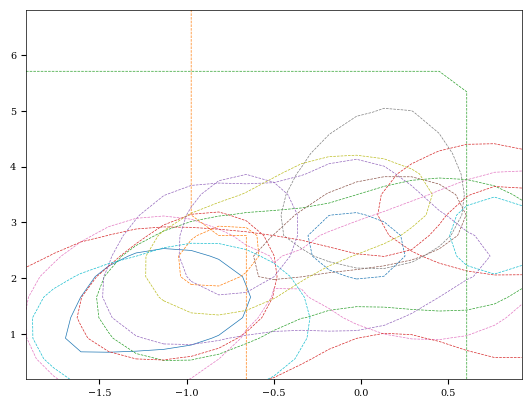

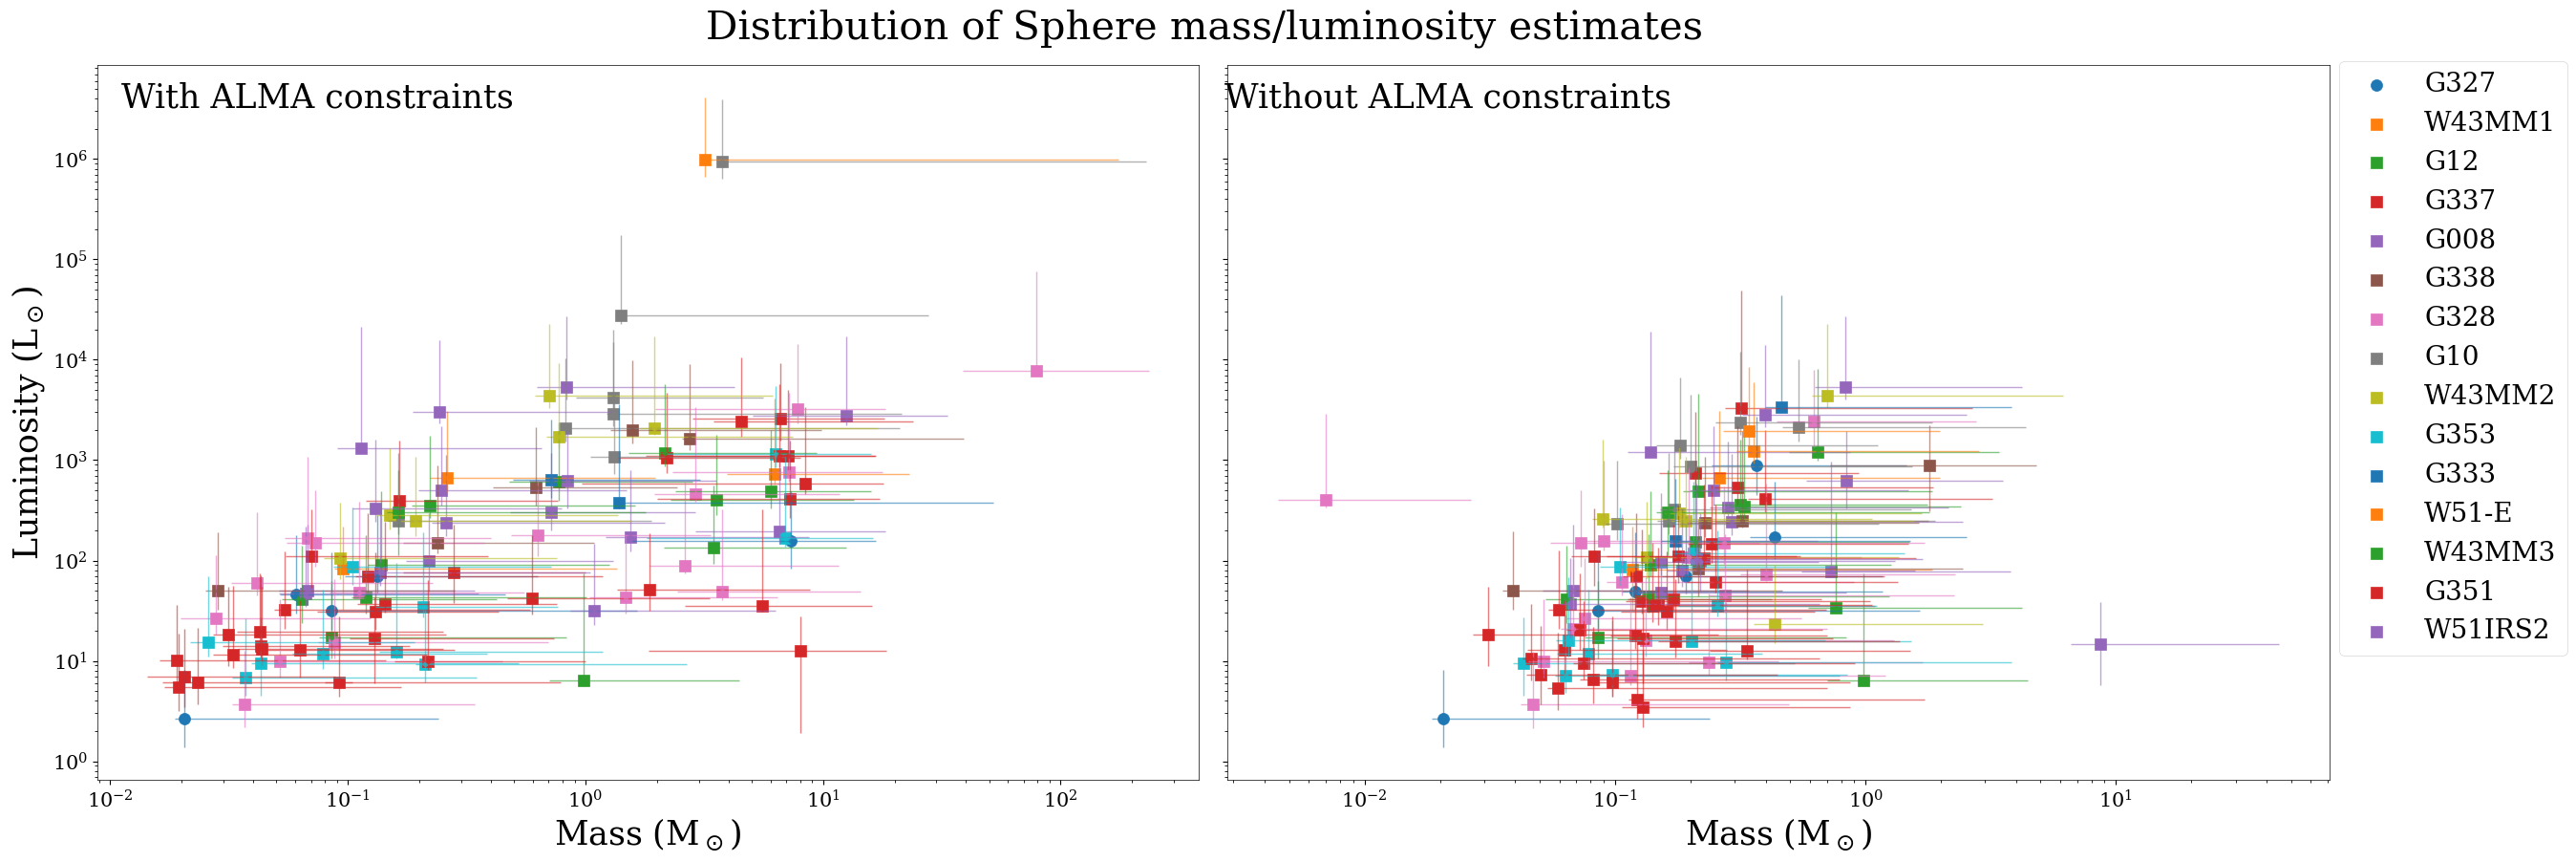

In [69]:
# WITH ALMA
#pl.rcParams['font.size'] = 14
massmode = 'Sphere'
# LOS, Sphere

masses = {}
masserrors = {}
luminosities = {}
luminosityerrors = {}
# all: glob.glob("Region_tables/Fitted/*")

fig2 = plt.figure()
axf2 = fig2.gca()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24, 8))
fig.tight_layout()
fig.set_facecolor("white")
for n in [0,1]:
    for fieldid in set([param_table, param_table_NoALMA][n]['ALMAIMF_FIELDID']):
        tbl = [param_table, param_table_NoALMA][n][np.where(param_table['ALMAIMF_FIELDID'] == fieldid)]
        masses[fieldid] = []
        masserrors[fieldid] = []
        luminosities[fieldid] = []
        luminosityerrors[fieldid] = []
        for row in tbl:
            mass = row[f"{massmode} mass mean"]
            masserror = row[f"{massmode} mass standard deviation"]
            #print(mass, masserror)
            luminosity = row[f"Luminosity mean"]
            luminosityerror = row[f"Luminosity standard deviation"]
            if np.any([z in [np.ma.masked,0.0,np.nan] for z in [mass,masserror,luminosity,luminosityerror]]):
                pass#print("Point rejected")
            else:
                #print("MASS",mass, masserror,"LUMINOSITY",luminosity, luminosityerror)
                masses[fieldid].append(mass)
                masserrors[fieldid].append(masserror)
                luminosities[fieldid].append(luminosity)
                luminosityerrors[fieldid].append(luminosityerror)
            
    ls = '-'
    marker = 'o'
    #pl.style.use('dark_background')
    for key in masses.keys():
        # MASS
        x = [10**z for z in masses[key]]
        xerr = masserrors[key]
        xerr_lower = [10**(masses[key][n]-masserrors[key][n]) for n in np.arange(len(masses[key]))]
        xerr_upper = [10**(masses[key][n]+masserrors[key][n]) for n in np.arange(len(masses[key]))]
        x_asymmetric_err = [xerr_lower, xerr_upper]
        # LUMINOSITY
        y = [10**z for z in luminosities[key]]
        yerr = luminosityerrors[key]
        yerr_lower = [10**(luminosities[key][n]-luminosityerrors[key][n]) for n in np.arange(len(luminosities[key]))]
        yerr_upper = [10**(luminosities[key][n]+luminosityerrors[key][n]) for n in np.arange(len(luminosities[key]))]
        y_asymmetric_err = [yerr_lower, yerr_upper]
        
        # fit the data with the fitter
        err = np.log10(np.array(yerr)/y) + np.log10(np.array(xerr)/x)
        fitted_line = fit(line_init, np.log10(x), np.log10(y), weights=1.0/err)
        
        if key == 'W43MM1':
            ls = '--'
            marker = 's'

        
        #ax.errorbar(x,y, xerr=xerr, yerr=yerr,fmt='.', alpha=0.5, elinewidth=1)

        [ax1,ax2][n].tick_params(axis="y", labelsize=15) 
        [ax1,ax2][n].tick_params(axis="x", labelsize=15) 
        [ax1,ax2][n].errorbar(x,y, xerr=x_asymmetric_err, yerr=y_asymmetric_err, fmt='.', alpha=0.6, elinewidth=1)
        sc = [ax1,ax2][n].scatter(x, y, label=key, s=75, marker=marker)
        # [ax1,ax2][n].plot(sorted(x), 10**fitted_line(sorted(np.log10(x))), color=sc.get_fc()[0], linestyle=ls)
        [ax1,ax2][n].set_xlabel(f"Mass (M$_\odot$)",fontsize=25)
        [ax1,ax2][n].loglog()
        [ax1,ax2][n].set_title(['With ALMA constraints','Without ALMA constraints'][n],fontsize=25,y=0.93,x=0.20)
                    
        if n == 0:
            bins = np.linspace(-2, 1, 20), np.linspace(0, 7, 20)
            H,bx,by = np.histogram2d(np.log10(x), np.log10(y), bins=bins)
            H2 = convolve(H, Gaussian2DKernel(2))
            cx = (bx[1:]+bx[:-1])/2.
            cy = (by[1:]+by[:-1])/2.
            con = axf2.contour(cx,
                               cy,
                               H2.T,
                               levels=[0.05, ],
                               colors=[sc.get_fc()[0]]*10,
                               linestyles=ls,
                               linewidths=0.5,
                               interpolation='bicubic',
                              )

        #ax.scatter([x[n]-xerr[n] for n in np.arange(len(x))], y,s=10)
        #ax.scatter([x[n]+xerr[n] for n in np.arange(len(x))], y,s=10)

fig.suptitle(f"Distribution of {massmode} mass/luminosity estimates",fontsize=30,y=1.05)    
ax1.set_ylabel("Luminosity (L$_\odot$)",fontsize=25)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.1,1),fontsize=20)
fig.show()

## Most Luminous YSO vs Field Luminosity

In [59]:
dellova = Table.read('/orange/adamginsburg/ALMA_IMF/catalogs/DellOvaSummary.txt', format='ascii')

# super hacky approach to make Brice's names match the DellOva table names
dellova.add_column(name='AIMF_short',
                   col=[x.split(".")[0].replace('-', '').replace('W51E', 'W51-E').replace("G01", "G1")
                        for x in dellova['AIMF']])
dellova.add_index('AIMF_short')
dellova.add_column(col=[np.nan]*len(dellova), name='MaxYSOLum')

In [65]:
for fieldid in set(param_table['ALMAIMF_FIELDID']):
    tbl = param_table[np.where(param_table['ALMAIMF_FIELDID'] == fieldid)]
    maxlum = tbl['Luminosity Median'].max()
    print(maxlum)
    dellova.loc[fieldid]['MaxYSOLum'] = maxlum

3.323485635511972
2.7941607461446303
3.07898015324291
3.4035559474176895
3.7383893823333203
3.3144661422126043
3.4302316182528054
6.050357092370399
3.6402529375970514
3.0812133333288414
2.7488732439476586
6.111577783550196
2.5029118168412783
3.0653239680378115
3.3067025960474723


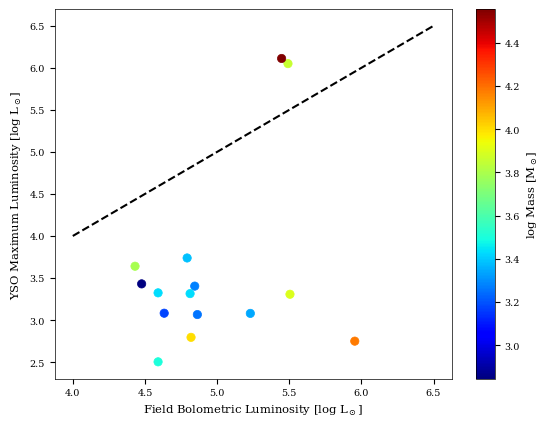

In [66]:
pl.scatter(np.log10(dellova['Lbol_Phot']), dellova['MaxYSOLum'], marker='o', c=np.log10(dellova['Mass_Phot']), cmap='jet')
pl.plot([4, 6.5], [4, 6.5], color='k', linestyle='--')
cb = pl.colorbar()
cb.set_label("log Mass [M$_\odot$]")
pl.xlabel("Field Bolometric Luminosity [log L$_\odot$]")
pl.ylabel("YSO Maximum Luminosity [log L$_\odot$]");
pl.savefig("SPICY_MostLuminousYSO_vs_FieldLuminosity.pdf", bbox_inches='tight')

In [68]:
dellova['AIMF', 'Lbol_Phot', 'Lbol_Foot', 'MaxYSOLum']

AIMF,Lbol_Phot,Lbol_Foot,MaxYSOLum
str8,int64,int64,float64
G008.67,62000,82000,3.7383893823333203
G010.62,310000,430000,6.050357092370399
G012.80,170000,310000,3.07898015324291
G327.29,39000,100000,3.323485635511972
G328.25,30000,46000,3.4302316182528054
G333.60,900000,1500000,2.7488732439476586
G337.92,70000,120000,3.4035559474176895
G338.93,65000,100000,3.3144661422126043
G351.77,73000,100000,3.0653239680378115


# Get best-guess parameter table

Returns a table of the best-fitting single model and its parameters for each source.

In [ ]:
robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2'
default_aperture=3000*u.au
extinction=make_extinction()

In [ ]:
spicyids = list(fit_results.keys())

In [151]:
def construct_bestfit_param_table(fit_results):
    
    spicyids = list(fit_results.keys())
    bestfit_param_table = None

    for spicyid in tqdm(spicyids):
        modelnames = [element for nestedlist in [fit_results[spicyid][geom]['model'] for geom in list(fit_results[spicyid].keys())[3:len(fit_results[spicyid])]] for element in nestedlist]
        chi2s = [element for nestedlist in [fit_results[spicyid][geom]['chi2'] for geom in list(fit_results[spicyid].keys())[3:len(fit_results[spicyid])]] for element in nestedlist]
        geoms = [element for nestedlist in [[geom for x in fit_results[spicyid][geom]['model']] for geom in list(fit_results[spicyid].keys())[3:len(fit_results[spicyid])]] for element in nestedlist]
        avs = [element for nestedlist in [fit_results[spicyid][geom]['av'] for geom in list(fit_results[spicyid].keys())[3:len(fit_results[spicyid])]] for element in nestedlist]
        scs = [element for nestedlist in [fit_results[spicyid][geom]['sc'] for geom in list(fit_results[spicyid].keys())[3:len(fit_results[spicyid])]] for element in nestedlist]
        
        bestfit_model = modelnames[chi2s.index(np.nanmin(chi2s))]
        bestfit_chi2 = chi2s[chi2s.index(np.nanmin(chi2s))]
        bestfit_geom = geoms[chi2s.index(np.nanmin(chi2s))]
        bestfit_av = avs[chi2s.index(np.nanmin(chi2s))]
        bestfit_distance = 10**scs[chi2s.index(np.nanmin(chi2s))] * u.kpc
        
        # memory cleanup
        del(modelnames,chi2s,geoms,avs,scs)
    
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{bestfit_geom}_augmented.fits')
        pars.add_index('MODEL_NAME')
    
        bestfit_params = Table(pars[pars.loc_indices[bestfit_model]])
    
        bestfit_params.add_column(spicyid, name='SPICY', index=0)
        bestfit_params.add_column(bestfit_chi2, name='chi2', index=2)
        bestfit_params.add_column(bestfit_distance, name='Distance',index=3)
        bestfit_params.add_column(bestfit_av, name='Av',index=4)
    
        # memory cleanup
        del(bestfit_model,bestfit_chi2,bestfit_geom,bestfit_av,bestfit_distance)
    
        if bestfit_param_table is None:
            bestfit_param_table = copy.deepcopy(bestfit_params)
            del(bestfit_params)
        else:
            bestfit_param_table = vstack([bestfit_param_table,bestfit_params])
            del(bestfit_params)

    return bestfit_param_table

In [152]:
bestfit_param_table = construct_bestfit_param_table(fit_results)

  0%|          | 0/118 [00:00<?, ?it/s]

In [147]:
bestfit_param_table.write(f'/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/param_table', format='fits', overwrite=True)